## Supervised Machine Learning - Conversion Rate Challenge

In [1]:
import pandas as pd
import numpy as np

# models to test
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
# metrics and tools
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV
# plot lib
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns
import plotly.graph_objects as go
# warnings handling
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) # to avoid deprecation warnings

In [2]:
df = pd.read_csv('src/conversion_data_train.csv')

In [3]:
df.shape

(284580, 6)

In [4]:
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [5]:
df.describe()

,age,new_user,total_pages_visited,converted
count,284580.000000,284580.000000,284580.000000,284580.000000
mean,30.564203,0.685452,4.873252,0.032258
std,8.266789,0.464336,3.341995,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [6]:
# Basic stats
print("Number of rows : {}".format(df.shape[0]))
print()

print("Basics infos: ")
data_desc = df.info()
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*df.isnull().sum()/df.shape[0])

Number of rows : 284580

Basics infos: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284580 entries, 0 to 284579
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              284580 non-null  object
 1   age                  284580 non-null  int64 
 2   new_user             284580 non-null  int64 
 3   source               284580 non-null  object
 4   total_pages_visited  284580 non-null  int64 
 5   converted            284580 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 13.0+ MB


None


Percentage of missing values: 


country                0.0
age                    0.0
new_user               0.0
source                 0.0
total_pages_visited    0.0
converted              0.0
dtype: float64

Correlation Heatmap



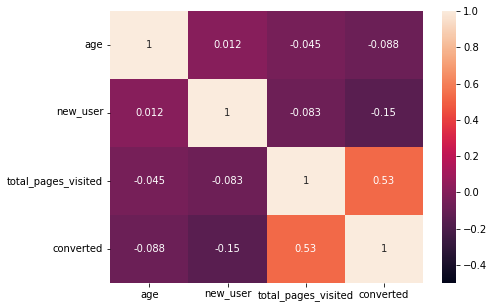

In [7]:
def get_correlation_info(df, size=(7, 5)):
    print("Correlation Heatmap")
    print()
    plt.figure(figsize=size)
    sns.heatmap(df.corr(), annot=True, vmin=-0.5, vmax=1)
    plt.show()

get_correlation_info(df)

## DATA CLEANING

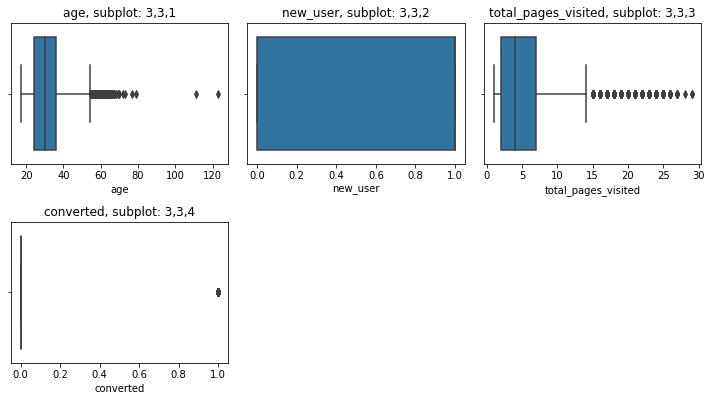

In [8]:
list_to_plot = df.drop(columns=['country','source'], axis=1)

a = 3  # number of rows
b = 3  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize=(10,8))

for i in list_to_plot:
    plt.subplot(a, b, c)
    plt.title('{}, subplot: {},{},{}'.format(i, a, b, c))
    plt.xlabel(i)
    sns.boxplot(x=df[i])
    c = c + 1

plt.tight_layout()
plt.show()

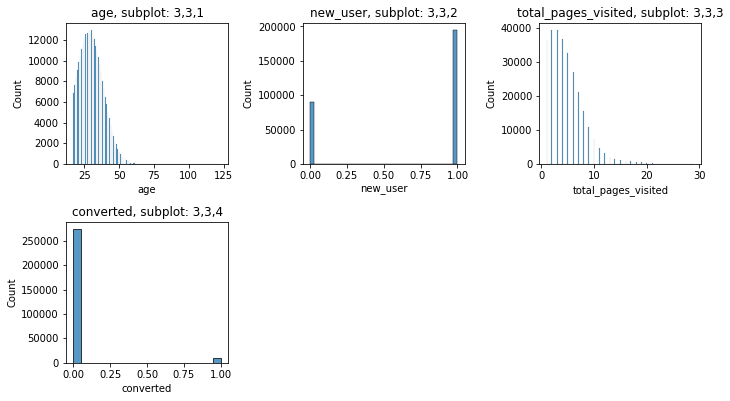

In [9]:

a = 3  # number of rows
b = 3  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize=(10,8))

for i in list_to_plot:
    plt.subplot(a, b, c)
    plt.title('{}, subplot: {},{},{}'.format(i, a, b, c))
    plt.xlabel(i)
    sns.histplot(df[i])
    c = c + 1

plt.tight_layout()
plt.show()

In [10]:
print(df.shape)
age_std = df['age'].std()
age_mean = df['age'].mean()
mask = df['age'].abs() < (age_mean + (3 * age_std))
df = df.loc[mask,:]
print(df.shape)

(284580, 6)
(283563, 6)


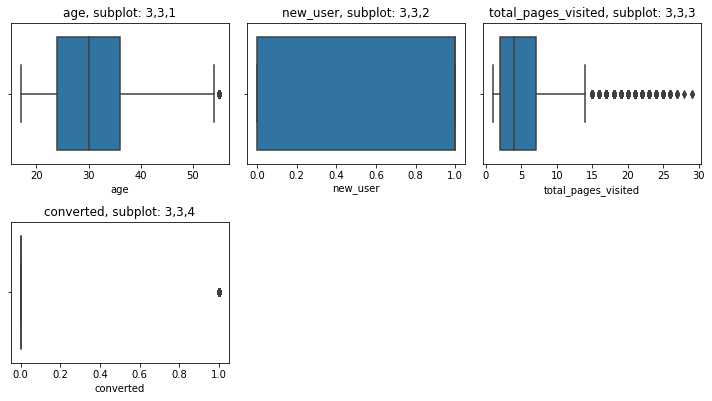

In [11]:
list_to_plot = df.drop(columns=['country','source'], axis=1)

a = 3  # number of rows
b = 3  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize=(10,8))

for i in list_to_plot:
    plt.subplot(a, b, c)
    plt.title('{}, subplot: {},{},{}'.format(i, a, b, c))
    plt.xlabel(i)
    sns.boxplot(x=df[i])
    c = c + 1

plt.tight_layout()
plt.show()

In [12]:
percentage_converted = (df['converted'] == 1).value_counts() / df.shape[0]
print(percentage_converted)
print()
print('Here the values from "converted" column :')
df['converted'].value_counts()

False    0.967651
True     0.032349
Name: converted, dtype: float64

Here the values from "converted" column :


0    274390
1      9173
Name: converted, dtype: int64

<AxesSubplot:xlabel='converted', ylabel='Count'>

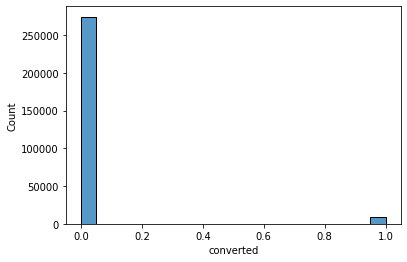

In [13]:
sns.histplot(df, x='converted')

##### *We notice that the target is significantly imbalanced*

## MACHINE LEARNING MODEL

### Testing several Machine Learning models on baseline :
- on a sample of our Dataframe (100 000 rows)
- preprocessing baseline (only 1 feature)
- test and comparate several models results on train & test set

In [14]:
df_sample = df.sample(100000)

num_features_list = ['total_pages_visited']
cat_features_list = []
features_list = [cat_features_list + num_features_list][0]

target_variable = 'converted'

X = df_sample.loc[:, features_list]
Y = df_sample.loc[:, target_variable]


# Create pipeline for numeric features
preprocessor = StandardScaler()

# Divide dataset Train set & Test set 

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0, \
                                                    stratify=Y)
#featureencoder = StandardScaler()
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
print("...Done")


...Done


In [15]:
classifier_lr = LogisticRegression(max_iter = 1000, class_weight='balanced')                                            
classifier_dt = DecisionTreeClassifier(class_weight='balanced')                                   
classifier_rfc = RandomForestClassifier(class_weight='balanced')                                       
classifier_adab = AdaBoostClassifier()                                                          
classifier_grad = GradientBoostingClassifier()                  

list_models = [classifier_lr, classifier_dt, classifier_rfc, classifier_adab, classifier_grad]

In [16]:
scores_df = pd.DataFrame(columns = ['model', 'f1_score_train', 'f1_score_test'])
scores_df.index = scores_df.index + 1

for model in list_models:
    classifier = model
    name_model = str(classifier.__class__).split(".")[-1][:-2]
    classifier.fit(X_train, Y_train)
    Y_train_pred = classifier.predict(X_train)
    Y_test_pred = classifier.predict(X_test)
    print()
    print(f"f1-score de {name_model} on train set : ", f1_score(Y_train, Y_train_pred).round(2))
    print(f"f1-score de {name_model} on test set : ", f1_score(Y_test, Y_test_pred).round(2))
    scores_df = scores_df.append({'model': name_model, \
    'f1_score_train': f1_score(Y_train, Y_train_pred).round(2), \
    'f1_score_test': f1_score(Y_test, Y_test_pred).round(2)}, ignore_index = True)

scores_df = scores_df.sort_values(by='f1_score_test', ascending=False)
scores_df.head(10)


f1-score de LogisticRegression on train set :  0.49
f1-score de LogisticRegression on test set :  0.48

f1-score de DecisionTreeClassifier on train set :  0.39
f1-score de DecisionTreeClassifier on test set :  0.38

f1-score de RandomForestClassifier on train set :  0.39
f1-score de RandomForestClassifier on test set :  0.38

f1-score de AdaBoostClassifier on train set :  0.7
f1-score de AdaBoostClassifier on test set :  0.68

f1-score de GradientBoostingClassifier on train set :  0.7
f1-score de GradientBoostingClassifier on test set :  0.68


,model,f1_score_train,f1_score_test
3,AdaBoostClassifier,0.70,0.68
4,GradientBoostingClassifier,0.70,0.68
0,LogisticRegression,0.49,0.48
1,DecisionTreeClassifier,0.39,0.38
2,RandomForestClassifier,0.39,0.38


### According to these results, we'll continue our project with 2 models:
- GradientBoostingClassifier
- AdaBoostClassifier

#### Gridsearch on : GradientBoostingClassifier

In [17]:
# Perform grid search
print("Grid search...")

model = GradientBoostingClassifier()   
# Grid of values to be tested
params = {
    'loss' : ['log_loss'], 
    'n_estimators': [200],
    'criterion' : ['friedman_mse'],
    'learning_rate':[0.1],
    'min_samples_split':[3]

}
print(params)
gridsearch = GridSearchCV(model, param_grid = params, cv=5) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)
print()
print("Accuracy on training set : ", gridsearch.score(X_train, Y_train))
print("Accuracy on test set : ", gridsearch.score(X_test, Y_test))
print()

Grid search...
{'loss': ['log_loss'], 'n_estimators': [200], 'criterion': ['friedman_mse'], 'learning_rate': [0.1], 'min_samples_split': [3]}
...Done.
Best hyperparameters :  {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'log_loss', 'min_samples_split': 3, 'n_estimators': 200}
Best validation accuracy :  0.9831666666666667

Accuracy on training set :  0.9831666666666666
Accuracy on test set :  0.9821



##### Quick test with GradientBoosingClassifier and his best hyperparameters :
- with only 1 feature
- On the sample of the dataset

In [18]:
classifier = GradientBoostingClassifier(n_estimators=200, min_samples_split=3)
classifier.fit(X_train, Y_train)
Y_train_pred = classifier.predict(X_train)
Y_test_pred = classifier.predict(X_test)
print()
print(f"f1-score de GradientBoostingClassifier on train set : ", f1_score(Y_train, Y_train_pred).round(2))
print(f"f1-score de GradientBoostingClassifier on test set : ", f1_score(Y_test, Y_test_pred).round(2))


f1-score de GradientBoostingClassifier on train set :  0.7
f1-score de GradientBoostingClassifier on test set :  0.68


#### Gridsearch on : AdaBoostClassifier

In [19]:
# Perform grid search
print("Grid search...")
model = AdaBoostClassifier()   
# Grid of values to be tested
params = {
    'n_estimators': [135],
    'algorithm' : ['SAMME'],
    'learning_rate':[0.005],
    'random_state' : [35]
}
print(params)
gridsearch = GridSearchCV(model, param_grid = params, cv=5) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)
print()
print("Accuracy on training set : ", gridsearch.score(X_train, Y_train))
print("Accuracy on test set : ", gridsearch.score(X_test, Y_test))
print()

Grid search...
{'n_estimators': [135], 'algorithm': ['SAMME'], 'learning_rate': [0.005], 'random_state': [35]}
...Done.
Best hyperparameters :  {'algorithm': 'SAMME', 'learning_rate': 0.005, 'n_estimators': 135, 'random_state': 35}
Best validation accuracy :  0.9831666666666667

Accuracy on training set :  0.9831666666666666
Accuracy on test set :  0.9821



##### Quick test with AdaBoostClassifier and his best hyperparameters :
- with only 1 feature
- On the sample of the dataset

In [20]:
classifier = AdaBoostClassifier(algorithm='SAMME', n_estimators=135, learning_rate=0.005, random_state=35)
classifier.fit(X_train, Y_train)
Y_train_pred = classifier.predict(X_train)
Y_test_pred = classifier.predict(X_test)
print()
print(f"f1-score de AdaBoostClassifier on train set : ", f1_score(Y_train, Y_train_pred).round(2))
print(f"f1-score de AdaBoostClassifier on test set : ", f1_score(Y_test, Y_test_pred).round(2))


f1-score de AdaBoostClassifier on train set :  0.7
f1-score de AdaBoostClassifier on test set :  0.68


### FEATURE ENGINEERING

In [21]:
df['age_X_total_pages_visit'] = df['age'] * df['total_pages_visited']

In [22]:
df.head(5)

,country,age,new_user,source,total_pages_visited,converted,age_X_total_pages_visit
0,China,22,1,Direct,2,0,44
1,UK,21,1,Ads,3,0,63
2,Germany,20,0,Seo,14,1,280
3,US,23,1,Seo,3,0,69
4,US,28,1,Direct,3,0,84


In [23]:
df.columns

Index(['country', 'age', 'new_user', 'source', 'total_pages_visited',
       'converted', 'age_X_total_pages_visit'],
      dtype='object')

### Preprocessing before **training** and **testing** our 2 models

In [24]:
cat_features_list = ['country', 'new_user', 'source']
num_features_list = [
                    'age', 
                    'total_pages_visited', 
                     'age_X_total_pages_visit'
                    ]

features_list = [cat_features_list + num_features_list][0]

target_variable = 'converted'

In [25]:
X = df.loc[:, features_list]
Y = df.loc[:, target_variable]

print('Explanatory variables : ', X.columns)
print()

Explanatory variables :  Index(['country', 'new_user', 'source', 'age', 'total_pages_visited',
       'age_X_total_pages_visit'],
      dtype='object')



In [26]:
# Create pipeline for categorical features
categorical_features = cat_features_list # Names of categorical columns in X_train/X_test
categorical_transformer = Pipeline(
    steps=[
   # ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])


In [27]:
# Create pipeline for numeric features
numeric_features = num_features_list # Names of numeric columns in X_train/X_test
numeric_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='median')), # missing values will be replaced by columns' median
    ('scaler', StandardScaler())
])


In [28]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [29]:
# Divide dataset Train set & Test set 
# 1 set for GradientBoostingClassifier
# 1 set for AdaBoostClassifier
# 1 set for our last and best model training on all data

print("Dividing into train and test sets...")
X_train_GRAD, X_test_GRAD, Y_train_GRAD, Y_test_GRAD = train_test_split(X, Y, test_size=0.1, random_state=0, \
                                                    stratify=Y)
X_train_ADA, X_test_ADA, Y_train_ADA, Y_test_ADA = train_test_split(X, Y, test_size=0.1, random_state=0, \
                                                    stratify=Y)   
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0, \
                                                    stratify=Y)                                        
print("...Done.")
print()


Dividing into train and test sets...
...Done.



In [30]:
print("Encoding categorical features and standardizing numerical features...")

X_train_GRAD = preprocessor.fit_transform(X_train_GRAD)
X_test_GRAD = preprocessor.transform(X_test_GRAD)
X_train_ADA = preprocessor.fit_transform(X_train_ADA)
X_test_ADA = preprocessor.transform(X_test_ADA)
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

print("...Done")

Encoding categorical features and standardizing numerical features...
...Done


### Training GradientBoostingClassifier:
 - With tuned hyperparameters
 - On all features + feature engineering
 - On all train set

#### Train & Test Pipeline

In [31]:
# Train model
print("Train model...")

classifier = GradientBoostingClassifier(n_estimators=200, min_samples_split=3)
classifier.fit(X_train_GRAD, Y_train_GRAD)

# Predictions on training set
print("Predictions on training set...")
Y_train_GRAD_pred = classifier.predict(X_train_GRAD)
print("...Done.")
print(Y_train_GRAD_pred)
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_GRAD_pred = classifier.predict(X_test_GRAD)
print("...Done.")
print(Y_test_GRAD_pred)
print(np.unique(Y_test_GRAD_pred))
print()


Train model...
Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]
[0 1]



#### Performance assessment

In [32]:
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score of GradientBoostingClassifier on train set : ", f1_score(Y_train_GRAD, Y_train_GRAD_pred).round(3))
print("f1-score of GradientBoostingClassifier on test set : ", f1_score(Y_test_GRAD, Y_test_GRAD_pred).round(3))

f1-score of GradientBoostingClassifier on train set :  0.768
f1-score of GradientBoostingClassifier on test set :  0.753


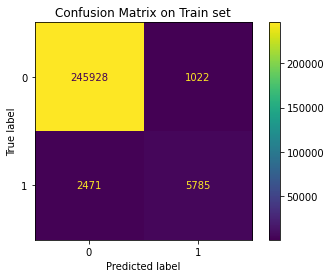

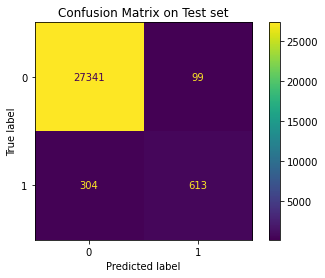

In [33]:
# Visualize confusion matrices
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier, X_train_GRAD, Y_train_GRAD, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier, X_test_GRAD, Y_test_GRAD, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

### Training AdaBoostClassifier:
 - With tuned hyperparameters
 - On all features + feature engineering
 - On all train set

#### Training & Test Pipeline

In [34]:
# Train model
print("Train model...")

classifier = AdaBoostClassifier(algorithm='SAMME', n_estimators=135, learning_rate=0.005, random_state=35)
classifier.fit(X_train_ADA, Y_train_ADA)

# Predictions on training set
print("Predictions on training set...")
Y_train_ADA_pred = classifier.predict(X_train_ADA)
print("...Done.")
print(Y_train_ADA_pred)
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_ADA_pred = classifier.predict(X_test_ADA)
print("...Done.")
print(Y_test_ADA_pred)
print(np.unique(Y_test_ADA_pred))
print()


Train model...
Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]
[0 1]



#### Performance assessment

In [35]:
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score of AdaBoostClassifier on train set : ", f1_score(Y_train_ADA, Y_train_ADA_pred).round(3))
print("f1-score of AdaBoostClassifier on test set : ", f1_score(Y_test_ADA, Y_test_ADA_pred).round(3))

f1-score of AdaBoostClassifier on train set :  0.697
f1-score of AdaBoostClassifier on test set :  0.679


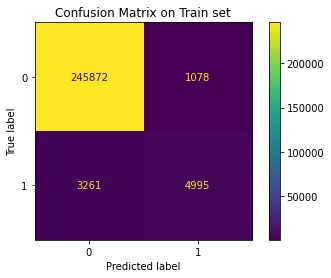

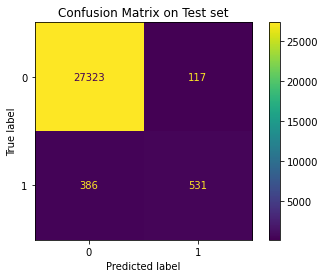

In [36]:
# Visualize confusion matrices
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier, X_train_ADA, Y_train_ADA, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier, X_test_ADA, Y_test_ADA, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

### Training our best model on all data :  **GradientBoostingClassifier** with:
 - all features + feature engineering
 - all train set **X_train + X-test**
 

In [37]:

X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

classifier = GradientBoostingClassifier(n_estimators=200, min_samples_split=3, random_state=42)
classifier.fit(X,Y)



GradientBoostingClassifier(min_samples_split=3, n_estimators=200,
                           random_state=42)

### Last step: predictions of our model on a dataset without target labels

In [38]:
# Read data without labels
data_without_labels = pd.read_csv('src/conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

# Apply our preprocessing 
data_without_labels['age_X_total_pages_visit'] = data_without_labels['age'] * data_without_labels['total_pages_visited']

X_without_labels = data_without_labels.loc[:, features_list]

Prediction set (without labels) : (31620, 5)


In [39]:
# Encoding categorical and numerical features
print("Encoding categorical features and standardizing numerical features...")
X_without_labels = preprocessor.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])


Encoding categorical features and standardizing numerical features...
...Done
[[-0.30412454  3.32563947  2.8040672   0.          1.          0.
   0.          0.          1.        ]
 [-1.04409044  0.03686198 -0.34782899  0.          1.          0.
   1.          1.          0.        ]
 [ 0.18918606 -1.15905711 -1.07518966  0.          0.          0.
   1.          0.          1.        ]
 [ 0.18918606  0.33584175  0.41683221  0.          0.          1.
   1.          0.          0.        ]
 [-0.67410749 -0.56109756 -0.67420878  0.          0.          0.
   0.          0.          1.        ]]


### Making predictions and dumping to file, according to the goals of this project:
- our file is a 'CSV file' with one column named 'converted' and no index
- our file must have format : 'conversion_data_test_predictions_[name].csv'
- where [name] is the name of our team/model separated by a '-'
- in this case : [name] = ChristopheD-finalmodel

In [40]:
# Making predictions and dumping to file
data = {
    'converted': classifier.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions_ChristopheD-finalmodel.csv', index=False)



### My conclusion is, if I had to go further on this project, I would:

- test others models, the first would be XGBoost
- Improve my feature engineering: New user column has a good correlation with the target,
is there a way to realize feature engineering from these data?
- Try over-sampling to fight against imbalanced data
